# Session 3: Visualisation and data processing

This material has been prepared by Vincent Post and will be presented on 17 June 2021

During this session we will look at data visualisation. We have already seen how easy it is to create good looking graphs in Python using the matplotlib library. While this is probably the most popular package for plotting, there are others as well, such as 

 - <A href="https://plotly.com/python/">plotly</A>, 
 - <A href="https://seaborn.pydata.org/">seaborn</A>
 - <A href="https://www.paraview.org/python/">paraview</A>
 - <A href="https://docs.enthought.com/mayavi/mayavi/">mayavi</A>
 
The latter two are for 3D plotting specifically. 

## 0. Three-dimensional plotting using matplotlib

Matplotlib has options to create 3D plots, albeit not as sophisticated as mayavi and paraview. It is still very useful for plotting relatively simple 3D graphs, such as flow paths calculated by a groundwater model. In the first example of this session, we will import the data from a pathline output file created by MODPATH. This could be handled using `numpy`'s `genfromtxt` function, but to make life a little easier, we will use the `flopy` library because it has a built-in function that will decipher the file structure automatically. Before continuing, you may want to view the contents of the file. As you can infer from its structure, there are 17 pathlines, each visualising the path of the groundwater to one of the 17 screens of two multi-level observation wells.

Before we can do anything, we have to import the packages that we will be using during this session. In order to use the 3D plotting functions of `matplotlib` we have to import from `mpl_toolkits.mplot3d` as well.

In [1]:
import flopy as fp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

%matplotlib notebook

Let's load the data first

In [2]:
fname = "flowpaths.mppth"
p = fp.utils.PathlineFile(fname)
npl = p.get_maxid() + 1 # There are 17 pathlines, yet get_maxid() returns 16 because counting starts at 0
print(f'Number of pathlines in {fname} = {npl}')

Number of pathlines in flowpaths.mppth = 17


That was easy! What happened in the background remains a little mysterious but we now have an object `p` which stores the x, y and z coordinates of the pathlines. It will become clear in the next code block how these can be accessed.

In order to create a 3D figure, it is necessary to specify that the projection of the axes as 3d, as shown in the first two lines of the code block. Because `flopy` already did the hard work of reading the file, the plotting of the pathlines is not all that hard. We loop over all the pathline ids, get the x, y and z coordinates that define the line and provide the `plot` command to draw them. Note that the variables `xll` and `yll` are used to convert the model coordinates to real-world coordinates. One the graph appears on the screen, you can tilt and rotate it using your mouse (holding the left button).

<IPython.core.display.Javascript object>


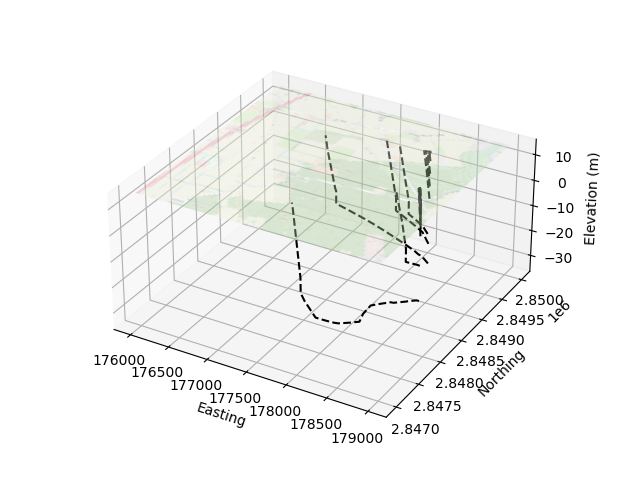

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xll, yll = 171310, 2840534
for i in range(p.get_maxid()+1):
    pi = p.get_data(partid=i)
    ax.plot(xll + pi['x'], yll + pi['y'], pi['z'], color='k', ls='--')

ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ax.set_zlabel("Elevation (m)")

ax.set_box_aspect(aspect = (1,1,0.5))

plt.tight_layout() # Makes optimal use of figure space

*Exercise*: All lines are now black. Think of a way to plot the lines of one of the wells in a certain colour, and the lines for the other well in a different colour. Hint: Seven pathlines go to the one well, and ten to the other.

Without a map, it is hard to get a good sense of where these lines are located. There is no official way to import a map into a 3D plot in `matplotlib`, but there is a trick. The `imread` function can be used to import bitmap images (in 'normal' 2D images, you can plot them using `imshow`). It is used here to open a png file that was created in QGIS. It contains OpenStreetMap (OSM) data for a specified region of which the corner coordinates are known. The values of the pixels in the image are used to define the facecolors of a `surface plot`. The plotted surface has as many cells as there are pixels in the image and is plotted at a fixed elevation. Note how the `alpha` keyworde is used to define the transparancy of the bitmap.

In [5]:
img = plt.imread("osm_flowpaths.png")

top = 15
y = np.linspace(2850000, 2847000, img.shape[0])
x = np.linspace(176000, 179000, img.shape[1])
z =  np.full((len(y), len(x)), top)
x, y = np.meshgrid(x, y)

ax.plot_surface(x, y, z, rstride=2, cstride=2, 
                facecolors=img, edgecolor='none', 
                linewidth=0,
                alpha=0.4, shade=False)

*Exercise*: Change the code block above so that the map has no transparancy. Also look up the meaning of `rstride` and `cstride` and try to improve the resolution of the graph.

Instead of using the mouse, the camera viewpoint of the 3D figure can also be changed using `ax.view_init(elev=x, azim=y)` where `x` and `y` are some number. You can create a `for` loop in which `x` or `y` (or both) gradually change. By calling the `plt.savefig` function after each update of the figure, a sequence of bitmap images can be saved, which can be stitched together to create a avi movie file. This is how the animation shown during the webinar prior to this course was created. A good piece of software to use for this is `mencoder`, which can be downloaded for free and works from the command line. Unfortunately we can not demonstrate this in the online environment, so the next section demonstrates a different way to create animations.

## 1. Animation

In the following example it will be demonstrated how the drawdown (i.e. the fall of the groundwater level) of an abstraction well as a function of time can be visualised in an animation. The first step is to define the function that calculates the drawdown of the well as a function of time $t$ and radial distance $r$

$s = \frac{Q}{4 \pi T} W(u)$

where $Q$ is the well abstraction rate, $T$ the aquifer transmissivity and $W(u)$ is the Theis well function, known as the exponential integral outside hydrogeology

$\int_u^\infty \frac{e^u}{u} du$

in which 

$u = \frac{r^2S}{4Tt}$

where $S$ is the aquifer storativity.

As luck would have it, the exponential integral is part of `scipy`'s special functions, so all we have to do is import it, and we can code up a function to calculate the drawdown according to the Theis equation.

In [6]:
from scipy.special import exp1

def theis(r, t, S, T, Q=100): # Q is a kwargt (keyword argument), it is optional and has a default value
    u = S * r ** 2 / (4.0 * T * t)
    s = Q / (4 * np.pi * T) * exp1(u)
    return s

With the function defined, we can create a graph that shows the drawdown for a given set of aquifer parameters after 0.1, 1, and 10 days since the well started pumping

<IPython.core.display.Javascript object>


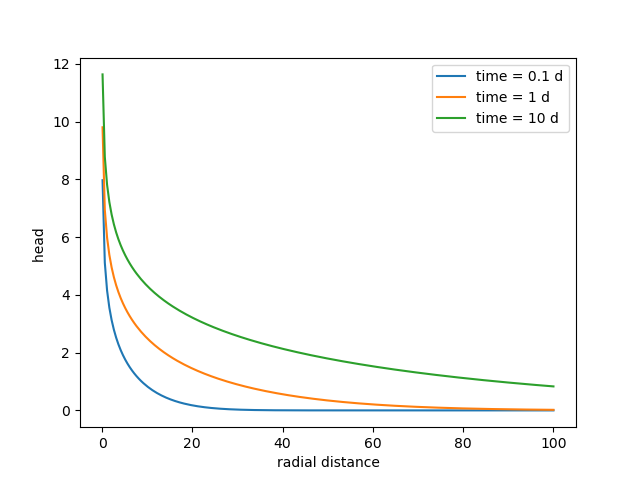

In [7]:
fig, ax = plt.subplots()
S = .01 # Storativity
T = 10 # Transmissivity
r = np.linspace(0.1, 100, 200) # Radial distance from well
for t in [0.1, 1, 10]: # Times
    ax.plot(r, theis(r, t, S, T), label = f'time = {t} d')

ax.set_xlabel('radial distance')
ax.set_ylabel('head ')
ax.legend(loc='best')

This does not look as nice as it could. A different way of visualizing is to show a single line and plot the different times one after another. This can be done interactively in `matplotlib` using the `FuncAnimation` function. In the following example, an empty graph is created first. The animation is created by `FuncAnimation`, which requires information about the figure that contains the graph to be animated, a function that does the actual updating, and the times to be passed to the `update` function. An `init` function is optional, it can be used to create the intial appearance of the graph.

In [8]:
from matplotlib.animation import FuncAnimation
r = np.linspace(0.1, 1000, 200)

fig, ax = plt.subplots()
ln, = ax.plot(r, np.zeros_like(r))
t_str = ax.text(800, 8, "t = {:0.1f} d".format(0),
                ha='center', va='center')

def init():
    ax.set_xlim(0, 1000)
    ax.set_ylim(10, 0)
    ax.grid(True, ls=':')

def update(t):
    ln.set_ydata(theis(r, t, S, T))
    t_str.set_text("t = {:0.2f} d".format(t))

ani = FuncAnimation(fig, update, frames=[0.1, 1, 10], init_func=init)

<IPython.core.display.Javascript object>

It works, but there is room for improvement! Before continuing, hit the blue/white on-off button in the upper right corner of the graph above to stop interaction. This will stop the animation and avoid any interference with  the next example, which is actually an exercise.

*Exercise*: Play around with the `frames` argument of the `FuncAnimation` function. Define a set of times that will result in a smooth looking animation. Hint: Look up the `logspace` function in `numpy`. This can be used to create an array with time intervals that are small initially and get bigger with time. This is useful because drawdown near the well changes rapidly in the beginning.

In [9]:
from matplotlib.animation import FuncAnimation
r = np.linspace(0.1, 1000, 200)

fig, ax = plt.subplots()
ln, = ax.plot(r, np.zeros_like(r))
t_str = ax.text(800, 8, "t = {:0.1f} d".format(0),
                ha='center', va='center')

def init():
    ax.set_xlim(0, 1000)
    ax.set_ylim(10, 0)
    ax.grid(True, ls=':')

def update(t):
    ln.set_ydata(theis(r, t, S, T))
    t_str.set_text("t = {:0.2f} d".format(t))

ani = FuncAnimation(fig, update, frames=np.logspace(-1, 2, 1000), init_func=init,
                    blit=True, interval=2, repeat=True)

<IPython.core.display.Javascript object>

The nice thing about this way of creating animations is that they can be saved to a video file directly from Python (no need for a tool like mencoder). See <A href="https://matplotlib.org/stable/api/animation_api.html">this page</A> for more information.

Before continuing remember to stop the animation by clicking the blue/white button again.

## 2. Optimisation

With the Theis equation defined, we can try to use it to do some parameter optimisation with it. In this case we will use measured drawdown data from Walton (1962) and try to estimate the aquifer transmissivity $T$ and storativity $S$. The spreadsheet is available in the repository, and below is a screenshot that show its contents.

![Screenshot of spreadsheet contents](walton_1962_screenshot.png)

*Exercise*: Use the `pandas` `read_excel` function to load the contents of the file walton_1962.xlsx.

In [10]:
xldata = pd.read_excel("walton_1962.xlsx", skiprows=[0,1,2,3,4,6], usecols="A,C")
xldata.tail()

,t,s
17,200,2.59080
18,260,2.80416
19,320,2.95656
20,380,3.10896
21,500,3.32232


In the previous sessions we have already seen how a model can be fitted to data in Python using least squares fitting. Here we will use the `lmfit` package, which has extensive functionality for parameter optimisation. It miniises an objective function, which is defined as follows

In [11]:
def residual(p, data, r):
    p_vals = p.valuesdict()

    times = data['t'].values
    s_meas = data['s'].values
    
    rv = (s_meas - theis(r, times, p_vals['S'], p_vals['T'], p_vals['Q']))
        
    return rv

Reading from the bottom up, the `residual` function returns the difference between the measured and calculated values at the times defined in the `data` `DataFrame` that is passed to the function as an argument. The parameters for the `theis` function are stored in a dictionary, which is part of the `lmfit` object that stores the parameters to be optimised. The code below shows how it is defined

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 22
    # variables        = 2
    chi-square         = 0.01692867
    reduced chi-square = 8.4643e-04
    Akaike info crit   = -153.735356
    Bayesian info crit = -151.553271
[[Variables]]
    S:  2.0948e-05 +/- 4.0268e-07 (1.92%) (init = 0.0001)
    T:  0.08545715 +/- 8.3719e-04 (0.98%) (init = 0.01)
    Q:  0.8327902 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(S, T) = -0.882


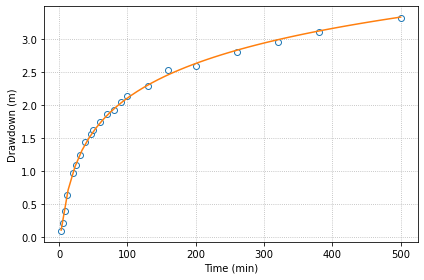

In [12]:
import lmfit as lm
# No need to interact with the graphs anymore from this point onward
%matplotlib inline 

Q = 220 # gpm
Q *= 0.00378541 # m3
r = 824 # ft
r *= 0.3048

p = lm.Parameters()
p.add('S', value = 1e-4, min = 0., vary = True)
p.add('T', value = 1e-2, min = 0., vary = True)
p.add('Q', value = Q, vary = False)

p_out = lm.minimize(residual, p, args=(xldata, r))
                    
print(lm.fit_report(p_out))

S = p_out.params['S'].value
T = p_out.params['T'].value

fig, ax = plt.subplots()
ax.plot(xldata['t'], xldata['s'], 'o', mfc='w', mec='C0')
t = np.linspace(xldata['t'].min(), xldata['t'].max())
ax.plot(t, theis(r, t, S, T, Q))

ax.set_xlabel("Time (min)")
ax.set_ylabel("Drawdown (m)")
#ax.set_xlim(0, 24)
#ax.set_ylim(0, 0.65)
ax.grid(True, ls=':')

plt.tight_layout()

*Exercise*: Change the appearance of the graph so that both axes are logarithmic. Let the time vary from 1 to 1000 min.

## 3. Linking with Google Earth

The Excel file `ameland_exercise.xlsx` contains multiple sheets with groundwater data on the island of Ameland in the Netherlands. The first sheet contains the coordinates of the observation wells where the head was measured. The other sheets contain the heads measured at four observation wells. The names of the sheets are the identification codes of the observation wells. The following code block creates a graph for each tabsheet in the spreadsheet file so that the data can be inspected visually

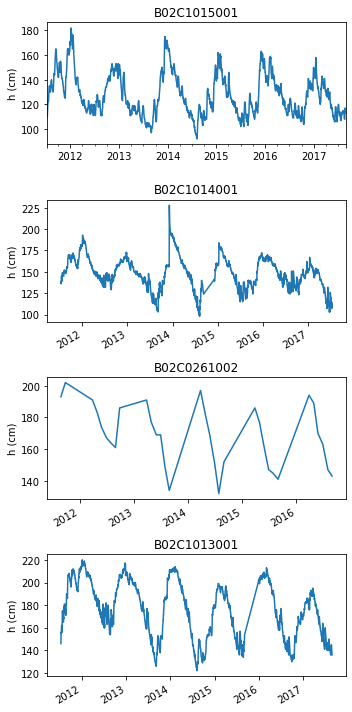

In [13]:
xldata = pd.read_excel('ameland_exercise.xlsx', sheet_name=None, index_col=0, parse_dates=True)
nc = len(xldata) - 1

fig, axs = plt.subplots(nrows=nc, figsize=(5,10))
for i, sheet in enumerate(xldata):
    if (i == 0): # Skip the first tabsheet with the coordinates
        continue

    ax = axs[i - 1]
    xldata[sheet].plot(ax=ax, legend=False)
    ax.set_title(sheet)
    ax.set_xlabel('')
    ax.set_ylabel('h (cm)')

plt.tight_layout()

The goal of this exercise is to create one graph for each piezometer and save it as a bitmap file. These bitmap files can be stored in a kmz file (see below) that can be loaded into Google Earth. Note that this is not expected to work easily in the online environment so this exercise is best done on your own computer.

We will first define a function that draws the graph, and then loop over the tabsheets to get the data. After the `for` loop has been executed, a png file will have been created for each of the piezometers stored in the spreadsheet file. Their names will be stored in the list `fnames`.

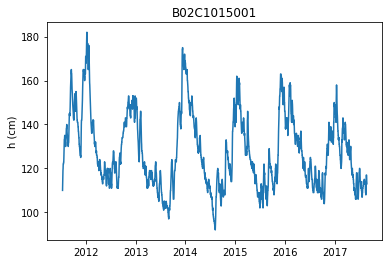

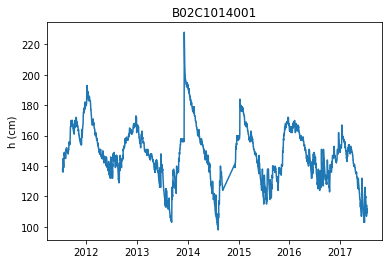

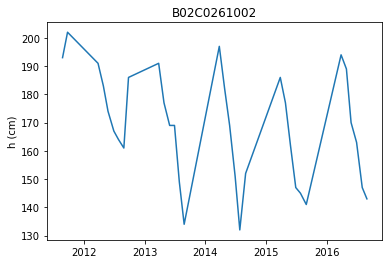

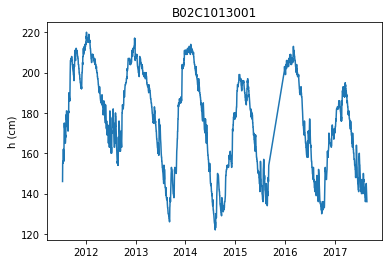

In [14]:

def plot_df(df):
    fig, ax = plt.subplots()
    ax.plot(df.index, df["head (cm amsl)"])
    ax.set_ylabel('h (cm)')
    ax.set_title(sheet)
    fname = f"{sheet}.png"
    plt.savefig(fname)
    
    return fname

for i, sheet in enumerate(xldata):
    if (i == 0):
        continue
    plot_df(xldata[sheet])


A KML file (Keyhole Markup Language) can be used to display geographic data on Google Earth or Google Maps. Here, we will use the package `simplekml` to create a KMZ file. A KMZ file is like a KML file, except that the graphs that we created can be packed (zipped, hence the z instead of an l in the filename extension) into it, which makes it much easier to distribute the file. 

The next code block shows how to extend the previous code block to create the kmz file

Index(['well_id', 'x', 'y', 'long', 'lat'], dtype='object')


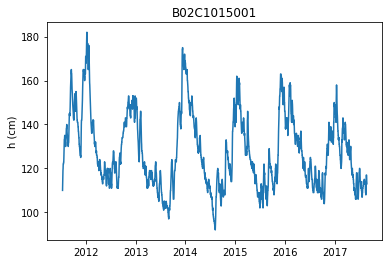

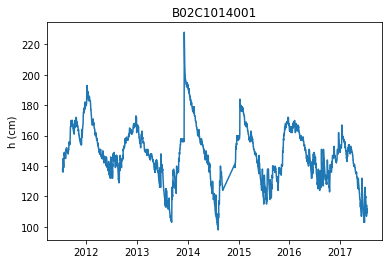

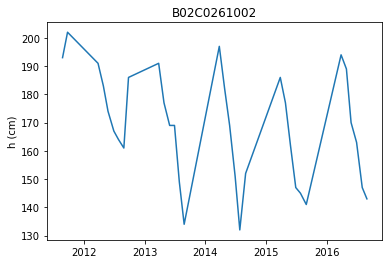

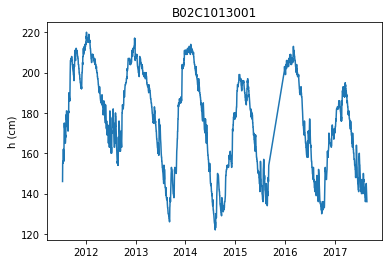

In [15]:
import simplekml

kmlfile = simplekml.Kml()

xldata = pd.read_excel('ameland_exercise.xlsx', sheet_name=None, index_col=0, parse_dates=True)
xydata = pd.read_excel('ameland_exercise.xlsx', sheet_name="coordinates")
print(xydata.columns)

for i, sheet in enumerate(xldata):
    if (i == 0):
        continue
    
    well_id = sheet[:-3]
    idx = xydata['well_id'] == well_id
    x = xydata['long'].loc[idx].values[0]
    y = xydata['lat'].loc[idx].values[0]

    fname = plot_df(xldata[sheet])

    path = kmlfile.addfile(fname)
    point = kmlfile.newpoint(name=well_id, coords=[[str(x), str(y)]])
    point.description = '<img src="' + path +'" alt={well_id} width="400" height="300" align="left" />'
    
kmlfile.savekmz('ameland.kmz', format=False)  # create kmz file

Finally, open the file in Google Earth. If it is not installed on your computer, you can also use the website [http://kmlviewer.nsspot.net](http://kmlviewer.nsspot.net) to view it.